In [1]:
import logging
from piny import YamlLoader
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

/Users/charaka/opt/anaconda3/envs/digital_finance/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sys.path.append("../src")

In [4]:
from utils import setup_logging
from data.loader.football_data import FootballData
from data.feature import EloRatingGenerator, WinStreakGenerator, GapRatingGenerator, PiRatingGenerator
from models.classifier_comparison import ClassifierComparison
from strategy import KellyCriterionStrategy, FixedFractionalStrategy, FractionalKellyCriterionStrategy, ConfidenceThresholdStrategy, DynamicFractionalKellyCriterionStrategy

### Setting up Environment 

In [5]:
print("Loading config file...")
config = YamlLoader(path="../src/config/config.yaml").load()
FOOTBALL_DATA_CONFIG = config["data"]
COLUMNS = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA']

print("Loading football data...")
football_dataset = FootballData.load(**FOOTBALL_DATA_CONFIG, columns=COLUMNS)

Loading config file...
Loading football data...


/Users/charaka/Desktop/Projects/value-sports-betting/notebooks/../src/utils.py:22: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(date_str, fmt)
/Users/charaka/Desktop/Projects/value-sports-betting/notebooks/../src/utils.py:22: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(date_str, fmt)
/Users/charaka/Desktop/Projects/value-sports-betting/notebooks/../src/utils.py:22: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(date_str, fmt)


### Generating the features 

In [6]:
elo_rating_generator = EloRatingGenerator()
win_streak_generator = WinStreakGenerator()
gap_rating_generator = GapRatingGenerator(input_features=[("FTHG", "FTAG"), ("HC", "AC")])
pi_rating_generator = PiRatingGenerator()

football_dataset.compute_features([elo_rating_generator, win_streak_generator, gap_rating_generator, pi_rating_generator])

label_encoder = LabelEncoder()
feature_columns = ['HomeEloBefore', 'AwayEloBefore', 'B365H', 'B365A', 'B365D', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'HomeGapAttackBefore', 
                'HomeGapDefendBefore', 'AwayGapAttackBefore', 'AwayGapDefendBefore','HomeStreakBefore', 'AwayStreakBefore', 'HomePiBefore', 'AwayPiBefore']

division = football_dataset.divisions['E0']

### Prepairing the dataframe

In [7]:
print("Preparing dataset")
df = division.dataframe
df = df.dropna(subset=feature_columns)
df['FTR'] = label_encoder.fit_transform(df['FTR'])

# model_features = ['HomePiBefore', 'AwayPiBefore', 'B365H', 'B365A', 'B365D', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA']
# model_features = ['HomeEloBefore', 'AwayEloBefore','HomeStreakBefore', 'AwayStreakBefore', 'B365H', 'B365A', 'B365D', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA']
model_features = ['HomeGapAttackBefore', 'HomeGapDefendBefore', 'AwayGapAttackBefore', 'AwayGapDefendBefore', 'B365H', 'B365A', 'B365D', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA']
X = df[model_features]
y = df['FTR']

# Split the data into train and test sets
print("Splitting data into train and test sets")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Preparing dataset
Splitting data into train and test sets


/var/folders/7r/wl3x6jwx2912f_7n3sv274kh0000gn/T/ipykernel_97272/2446055856.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FTR'] = label_encoder.fit_transform(df['FTR'])


### Building and comparing models

In [8]:
from sklearn.metrics import log_loss
import numpy as np

### Use of Log-loss for evaluation of classification models

In the context of sports betting, where we are predicting the outcomes of football matches, log-loss serves as an ideal performance metric for several reasons. Primarily, in a betting environment, the prediction of the outcome is not simply a binary or multi-class problem, but rather the confidence in the predicted outcome also holds significant importance. This is because the stakes on a bet are often determined by the confidence in the predicted outcome.

The log-loss metric precisely quantifies this by evaluating not just the predicted class, but the probabilities associated with each predicted class. By doing so, it provides a more comprehensive view of the model's performance by considering both the accuracy of the predictions and the confidence in each prediction.

One of the key advantages of log-loss in the sports betting context is that it promotes well-calibrated probabilities. In other words, it rewards the models that are able to correctly estimate the true underlying probabilities of the outcomes. This attribute is critical in betting where the profitability of a betting strategy is not just determined by predicting the correct outcome, but also correctly estimating the odds.

Furthermore, log-loss penalises models that make confident yet incorrect predictions. This characteristic is particularly beneficial in a betting scenario, as overconfident predictions can lead to large losses. A model that is less confident and predicts probabilities close to 0.5 for all outcomes will often achieve a better log-loss score than a model that makes confident but incorrect predictions.

Therefore, when developing models for a betting strategy, using log-loss as the optimisation metric is an appropriate choice. It encourages the model to make well-calibrated and cautious predictions, which aligns with the overall goal of maximising the profitability of the betting strategy.

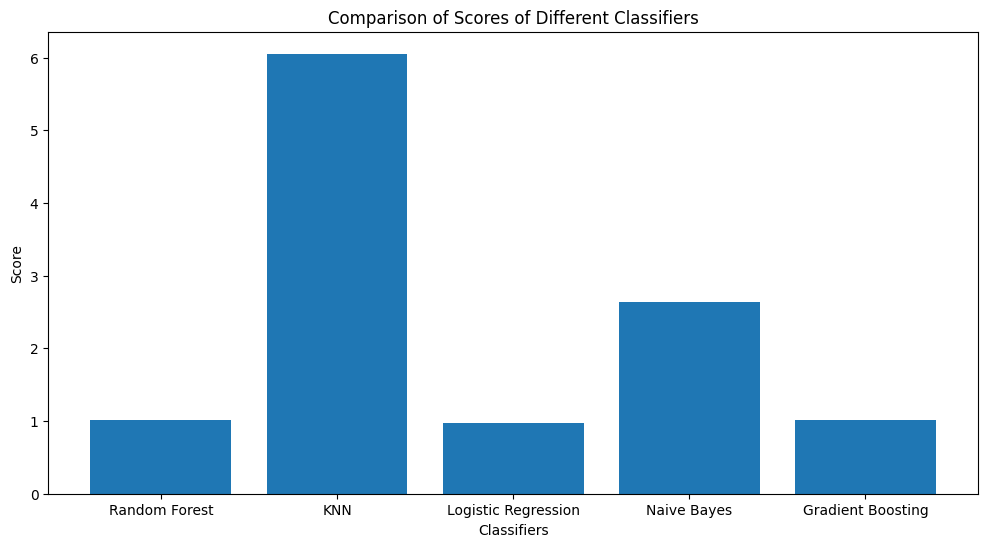

Scores: {'Random Forest': 1.0170468527571122, 'KNN': 6.053549088254653, 'Logistic Regression': 0.9710916622131561, 'Naive Bayes': 2.6341865472600645, 'Gradient Boosting': 1.0136263840754036}
Best classifier: Logistic Regression | Score: 0.97


In [9]:
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    # 'SVC': make_pipeline(StandardScaler(), SVC()),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

classifier_comparison = ClassifierComparison(classifiers)
labels = np.unique(y_test)
classifier_comparison.fit_and_score(X_train, y_train, X_test, y_test, score_func=log_loss, labels=labels)
classifier_comparison.plot_scores()
best_classifier = classifier_comparison.best_classifier(greater_is_better=False)
print(f"Scores: {classifier_comparison.scores}")
print(f"Best classifier: {best_classifier} | Score: {classifier_comparison.scores[best_classifier]:.2f}")

#### ⚠️ **Lower log-loss the better the model**

Starting bankroll: 1000
Ending bankroll: 2580.6651968365


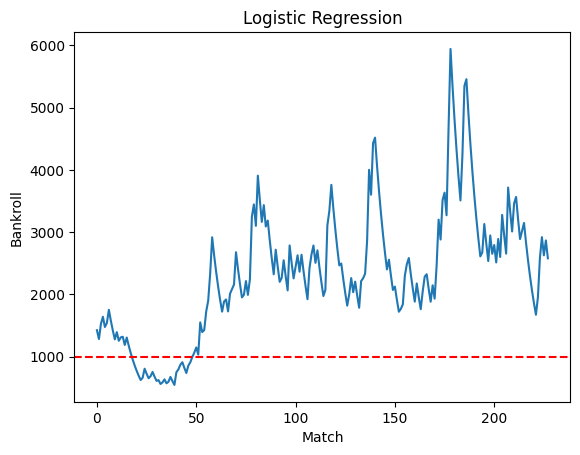

In [65]:
classifier_name = best_classifier
classifier = classifiers[classifier_name]

# strategy = KellyCriterionStrategy(label_encoder)
strategy = FixedFractionalStrategy(label_encoder, fraction=0.1)
# strategy = ConfidenceThresholdStrategy(label_encoder, confidence_threshold=0.5, bet_size=0.1)
# strategy = FractionalKellyCriterionStrategy(label_encoder, fraction=0.15)
# strategy = DynamicFractionalKellyCriterionStrategy(label_encoder, min_fraction=0.15, max_fraction=0.35)
print(f'Starting bankroll: {strategy.bankroll}')

# Run the strategy
strategy.run(X_test, y_test, classifier)
print(f'Ending bankroll: {strategy.bankroll}')

sns.lineplot(data=strategy.history, x='Match', y='Bankroll').set_title(classifier_name)
plt.axhline(1000, color='r', linestyle='--')
plt.show()

In [66]:
strategy.history

,Match,Bet,Stake,Outcome,ProfitLoss,Bankroll,Odds
0,0,H,100.000000,Win,425.000000,1425.000000,5.25
1,1,H,142.500000,Loss,-142.500000,1282.500000,4.00
2,2,A,128.250000,Win,243.675000,1526.175000,2.90
3,3,H,152.617500,Win,114.463125,1640.638125,1.75
4,4,D,164.063813,Loss,-164.063813,1476.574312,3.75
...,...,...,...,...,...,...,...
223,223,H,195.780539,Win,626.497726,2584.303120,4.20
224,224,H,258.430312,Win,335.959406,2920.262526,2.30
225,225,H,292.026253,Loss,-292.026253,2628.236273,2.25
226,226,A,262.823627,Win,239.169501,2867.405774,1.91


In [68]:
strategy.metric_report()

{'Total Profit': 1580.6651968365009,
 'Total Staked': 52816.933419444715,
 'Current Bankroll': 2580.6651968365,
 'Standard Deviation of Returns': 1.4363416541874383,
 'Value at Risk (95%)': -516.2070523697046,
 'ROI': 2.9927242921956054,
 'Hit Rate': 0.4780701754385965,
 'Volatility': 351.84274387315685,
 'Max Drawdown': 4271.205244167344}

In [13]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Initialize a figure for the gridplot
# fig, axs = plt.subplots(len(classifiers), figsize=(15, 20))

# # Run the strategy for each classifier and plot the results
# for i, (name, classifier) in enumerate(classifiers.items()):
#     # Initialize the Kelly Criterion Strategy
#     print(f'Running {name}...')
#     strategy = ConfidenceThresholdStrategy(label_encoder, confidence_threshold=0.5, bet_size=0.1)
#     print(f'Starting bankroll: {strategy.bankroll}')

#     # Run the strategy
#     strategy.run(X_test, y_test, classifier)
#     print(f'Ending bankroll: {strategy.bankroll}')
    
#     # Plot the history
#     sns.lineplot(data=strategy.history, x='Match', y='Bankroll', ax=axs[i]).set_title(name)

# plt.tight_layout()
# plt.show()


In [14]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import make_scorer, log_loss

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 5, 10, 15],
#     'min_samples_split': [2, 5, 10]
# }

# # Create a scorer
# log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# # Create the GridSearchCV object
# grid_search = GridSearchCV(
#     RandomForestClassifier(random_state=42), 
#     param_grid, 
#     cv=5, 
#     scoring=log_loss_scorer,
#     verbose=1
# )

# # Fit the GridSearchCV object to the data
# grid_search.fit(X_train, y_train)

# # Print the best parameters and the corresponding score
# print("Best parameters: ", grid_search.best_params_)
# print("Best log loss: ", grid_search.best_score_)
